In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import random

# Make sure that caffe is on the python path:
caffe_root = '/raid/linjieli/caffe/'  # this file is expected to be in {caffe_root}/examples/siamese
pretrained_model_root = '/raid/linjieli/caffe/'
import sys
sys.path.insert(0, pretrained_model_root + 'python')

import caffe

#Load the trained net
#
# Remember to change the MODEL_FILE depending on the architecture !!!
MODEL_FILE = caffe_root +'models/sraonet/siamese_lecun_deploy.prototxt'
#VALI_FILE = caffe_root + 'models/sraonet/siamese_imagenet_val_3conv_finetune.prototxt
PRETRAINED_FILE = caffe_root + 'models/sraonet/snapshots/sraonet_lecun_gd_sub1_iter_200000.caffemodel'
# decrease if you want to preview during training 

#image_dir = "/raid/linjieli/starNow/subTrain/"
#mean = np.load(pretrained_model_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
caffe.set_device(1)
caffe.set_mode_gpu()
if not os.path.isfile(PRETRAINED_FILE):
    print("No caffemodel!!!")
elif not os.path.isfile(MODEL_FILE):
    print("No MODEL !!!")
else:
    print "Defining the net!"
    net = caffe.Net(MODEL_FILE,
                PRETRAINED_FILE,
                caffe.TEST)

Defining the net!


In [2]:
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB



featureNum = net.params['fc6'][1].data.shape[0]
# print net.params['fc8_flickr'][1].data.shape

In [3]:
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

features = np.zeros([36,100,featureNum])
img_type_map = {}
img_type_index = {}
img_name = {}
type_index = 0
totalNum = 0
# read in image list 
def readFile(fName):
    text_file = open(fName, "r")
    lines = text_file.read().split('\n')
    text_file.close()
    return lines
imList = readFile("/raid/linjieli/faceSimilarity/list/GURUList/subTrainSubList.txt")
#print len(imList)
for img2 in imList:
    imgName = os.path.basename(img2)
    if imgName.lower().endswith(".jpg"):
        totalNum +=1
        img2_type = imgName.lower().split('_')[0]
#         print img2_type
#         print imgName
        if img2_type in img_type_map.keys():
            img_type_map[img2_type] = img_type_map[img2_type] + 1
            img_name[img2_type] = img_name[img2_type] + [img2]
        else:
            img_type_map[img2_type] = 0
            img_name[img2_type] = [img2]
            img_type_index[img2_type] = type_index
            type_index +=1
        input_image = caffe.io.load_image(img2)
        net.blobs['data'].reshape(1,3,56,46)
        net.blobs['data'].data[...] = transformer.preprocess('data', input_image)
        out = net.forward()
        feat = out['fc6']
#         fig = pylab.figure()
#         plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
    features[img_type_index[img2_type],img_type_map[img2_type]] = feat.flatten()
print len(img_type_map)
print totalNum
print max(img_type_map.values())
features = features[:36,:max(img_type_map.values()),:featureNum]
#print features

36
730
42


42


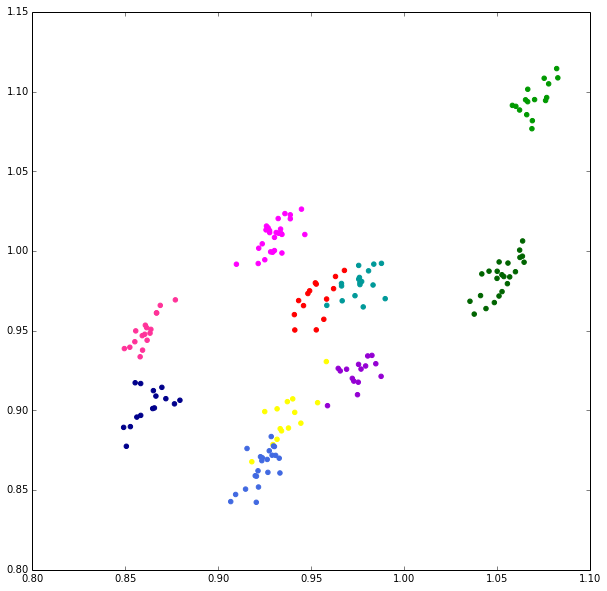

In [59]:
print max(img_type_map.values())
import matplotlib.pyplot as plt
import matplotlib.cm as cm
c = ['yellow', '#ff3399', 'red', 'darkblue', 'royalblue', 
    '#ff00ff', 'darkviolet', 'darkgreen', '#009900', '#009999']
#colors = iter(cm.rainbow(np.linspace(0, 1, len(img_type_map.keys()))))
Keys = img_type_map.keys()
plotNum = 0
for i in range(plotNum,plotNum+10):
    #print Keys[i]
    plt.scatter(features[img_type_index[Keys[i]],0:img_type_map[Keys[i]],10], \
                features[img_type_index[Keys[i]],0:img_type_map[Keys[i]],13],color=c[i-plotNum])
plt.show()

[ 0.4437504   0.25282689  0.19746741  0.10352053]


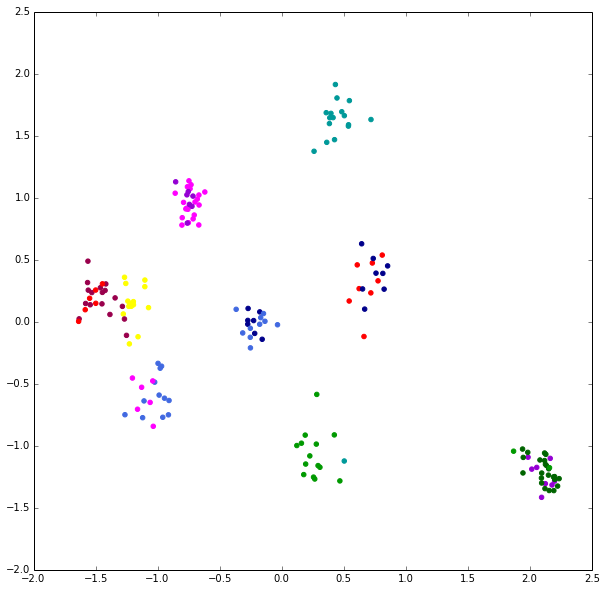

In [56]:
#print features
featureMat = np.zeros((totalNum,featureNum))
k = 0
for i in range(features.shape[0]):
    #print features[i].shape[0]
    for j in range(features[i].shape[0]):
        if sum(features[i,j,:])!=0:
            #print k
            featureMat[k,:] = features[i,j,:]
            k +=1
#print featureMat 
from sklearn.decomposition import PCA as sklearnPCA
explained_variance = 0.99
sklearn_pca = sklearnPCA(n_components=explained_variance, whiten  = True)
sklearn_transf = sklearn_pca.fit_transform(featureMat)
print sklearn_pca.explained_variance_ratio_
# print sklearn_transf.shape

import matplotlib.pyplot as plt
import matplotlib.cm as cm
c = ['yellow', '#99004C', 'red', 'darkblue', 'royalblue', 
    '#ff00ff', 'darkviolet', 'darkgreen', '#009900', '#009999']
# colors = iter(cm.rainbow(np.linspace(0, 1, len(img_type_map.keys()))))
Keys = img_type_map.keys()
#print Keys
past = 0
plotNum = 0
for i in range(plotNum,plotNum+10):
#     print img_type_map[Keys[i]]
#     print Keys[i]
#     print img_name[Keys[i]]
    plt.scatter(sklearn_transf[past:img_type_map[Keys[i]]+past,0], \
                sklearn_transf[past:img_type_map[Keys[i]]+past,1],color=c[i-plotNum])
#     print c[i-plotNum]
#     print sklearn_transf[past:img_type_map[Keys[i]]+past,0]
#     print sklearn_transf[past:img_type_map[Keys[i]]+past,:]
    past += img_type_map[Keys[i]]
plt.show()




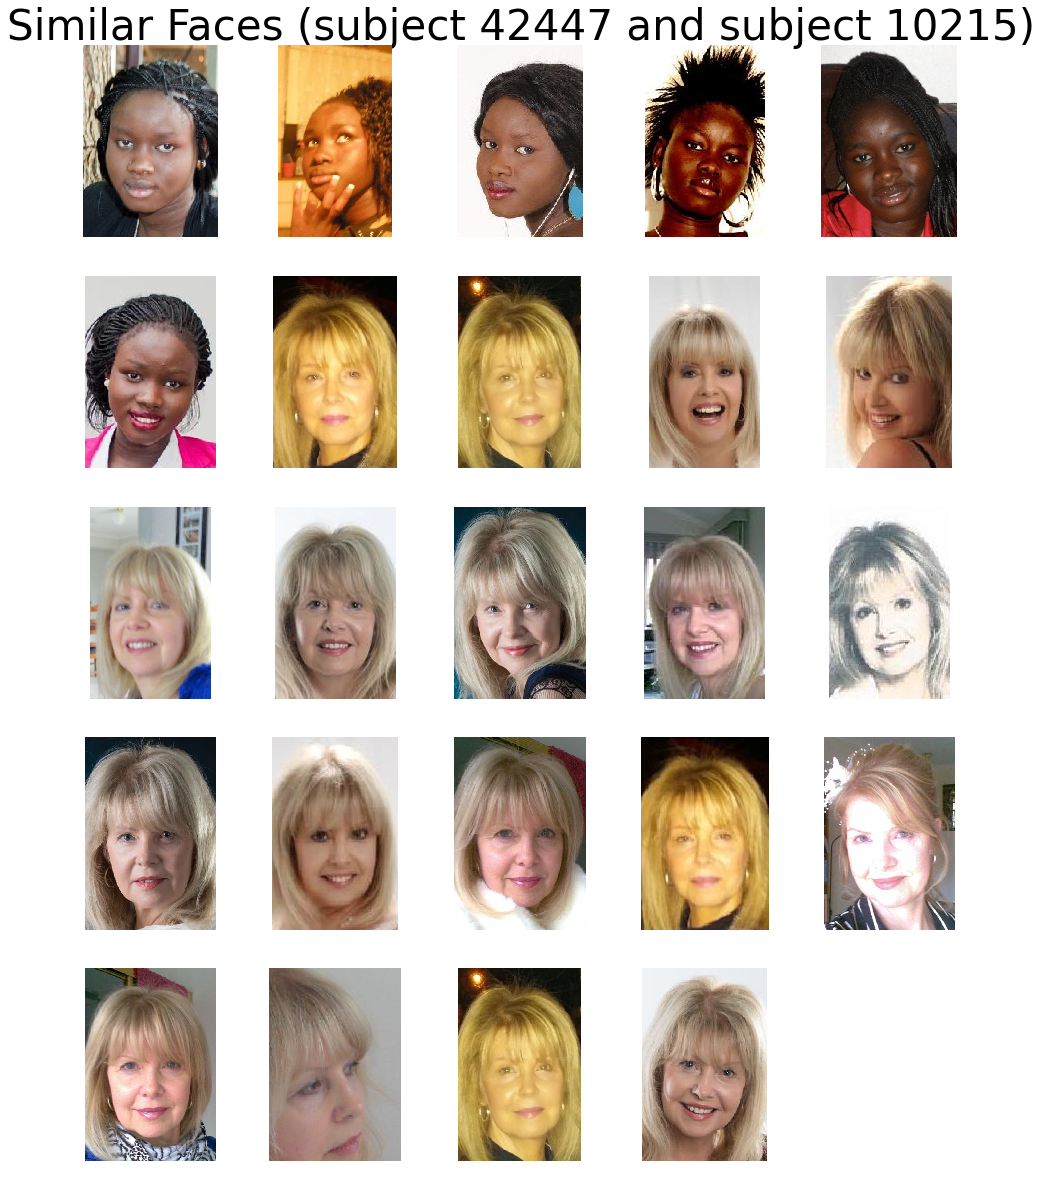

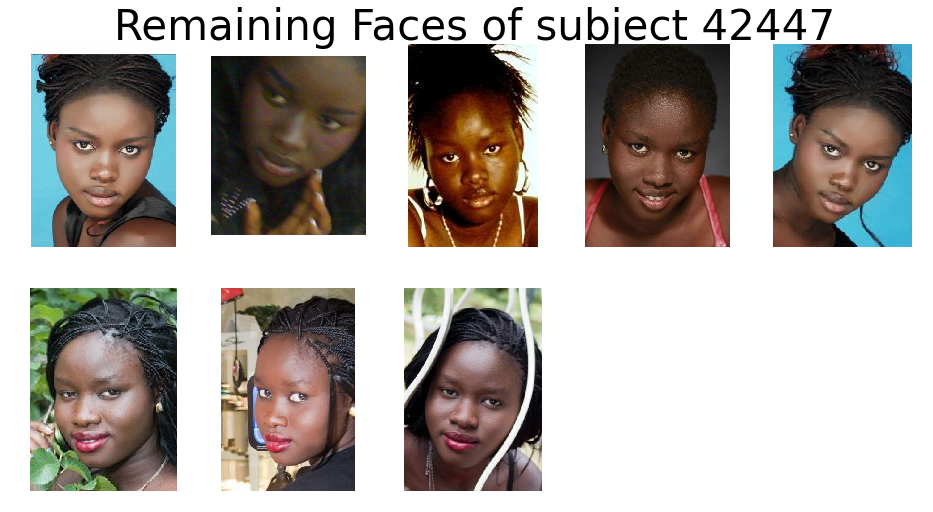

In [57]:
from PIL import Image
import math
plot_img = img_name['42447'][:6]+img_name['10215']
# print plot_img
# # for i in range(0,4): 
# plot_img = set(img_path_pca[i][::int(math.floor(float(len(img_path_pca[i]))/40))])
MODEL = 'faceSNN'
saveFigPath = '/raid/linjieli/faceSimilarity/attractive/Result/'+MODEL
f = pylab.figure(figsize = (16,20))
pylab.title("Similar Faces (subject 42447 and subject 10215)",fontsize = 42)
plt.axis('off')
for n, fname in enumerate(plot_img):
    image=Image.open(fname)
    arr=np.asarray(image)
    f.add_subplot(math.ceil(float(len(plot_img))/5), 5, n+1)  # this line outputs images on top of each other
    # f.add_subplot(1, 2, n)  # this line outputs images side-by-side
    pylab.imshow(arr)
    plt.axis('off')
pylab.show()
f.tight_layout()
f.savefig(saveFigPath+"/similarPCAFaces.jpg", dpi=300)

plot_img = img_name['42447'][7:]
f = pylab.figure(figsize = (16,8))
pylab.title("Remaining Faces of subject 42447 ",fontsize = 42)
plt.axis('off')
for n, fname in enumerate(plot_img):
    image=Image.open(fname)
    arr=np.asarray(image)
    f.add_subplot(math.ceil(float(len(plot_img))/5), 5, n+1)  # this line outputs images on top of each other
    # f.add_subplot(1, 2, n)  # this line outputs images side-by-side
    pylab.imshow(arr)
    plt.axis('off')
pylab.show()
f.tight_layout()
f.savefig(saveFigPath+"/remainingPCAFaces.jpg", dpi=300)

In [6]:
import pickle
np.savetxt('feature_pca_trainSub.csv', sklearn_transf, delimiter=',')
np.savetxt('feature_trainSub.csv',featureMat,delimiter = ',')

In [24]:
#print features[img_type_index[img2_type],img_type_map[img2_type]]
img_index_name_map = dict()
for key in img_name.keys():
    img_index_name_map[img_type_index[key]] = img_name[key]
with open('trainSub_imgIndex_name.pickle', 'wb') as handle:
    pickle.dump(img_index_name_map, handle)

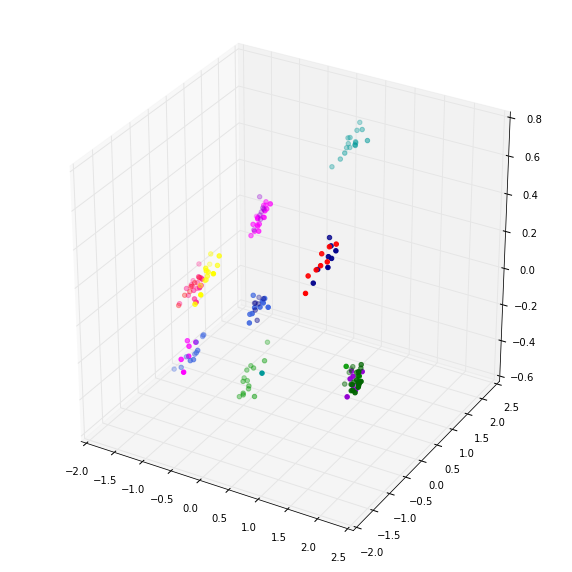

In [25]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
past = 0
plotNum = 0
for i in range(plotNum,plotNum+10):
#     print img_type_map[Keys[i]]
#     print Keys[i]
    ax.scatter(sklearn_transf[past:img_type_map[Keys[i]]+past,0], \
                sklearn_transf[past:img_type_map[Keys[i]]+past,1],\
               sklearn_transf[past:img_type_map[Keys[i]]+past,2],color=c[i-plotNum])
#     print sklearn_transf[past:img_type_map[Keys[i]]+past,:]
    past += img_type_map[Keys[i]]
plt.show()

In [26]:
#print features
featureMat = np.zeros((trainFullLen,50))
k = 0
for i in range(features.shape[0]):
    #print features[i].shape[0]
    for j in range(features[i].shape[0]):
        if sum(features[i,j,:])!=0:
            #print k
            featureMat[k,:] = features[i,j,:]
            k +=1
#print featureMat
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
sklearn_transf = sklearn_pca.fit_transform(featureMat)
print sklearn_pca.explained_variance_ratio_


import matplotlib.pyplot as plt
import matplotlib.cm as cm
# c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
#      '#ff00ff', '#990000', '#999900', '#009900', '#009999']
# c = ['yellow', '#ffff00', 'red', 'darkblue', 'royalblue', 
#      '#ff00ff', 'darkviolet', 'darkgreen', '#009900', '#009999']
#colors = iter(cm.rainbow(np.linspace(0, 1, len(img_type_map.keys()))))
Keys = img_type_map.keys()
past = 0
for i in range(10):
    print img_type_map[Keys[i]]
    plt.scatter(sklearn_transf[past:img_type_map[Keys[i]]+past,0], \
                sklearn_transf[past:img_type_map[Keys[i]]+past,1],color=c[i])
    past += img_type_map[Keys[i]]
plt.show()

NameError: name 'trainFullLen' is not defined